## Welcome to the basic neural network tutorial!
The following notebook is designed to walk through the process of building and training your first neural network using the standalone MaCh3 python utilities!

If you're writing scripts this is encapsulate in the objects in `MaCh3PythonUtils/config_reader` however this guide aims to break apart the process of writing the code for yourself!

The first step is to load in a MaCh3 MCMC fit as input file. This is done using the ChainHandler class!

In [16]:
# MaCh3Python Deps
from MaCh3PythonUtils.file_handling.chain_handler import ChainHandler
from MaCh3PythonUtils.machine_learning.ml_factory import MLFactory

import tensorflow as tf

# Other imports
from matplotlib import pyplot as plt
from pathlib import Path
import gdown

In [17]:
# Download file from google drive

file_url="https://drive.google.com/file/d/1iE6xFhn3BH_HnLUfQ7KFGy2wfeH52Rwf/view?usp=sharing"

# download the file
input_file = Path("../models/demo_chain.root")

if not input_file.exists():
    # download the file
    input_file.parent.mkdir(parents=True, exist_ok=True)
    gdown.download(file_url, str(input_file), quiet=False, fuzzy=True)


In [18]:
# Load in a file, for the purposes of this example we'll use a
# input_file = Path("../../../../T2K/AdaptiveTune/SummerProj/Adapt/NOvA/LongFit/Cut/mcmc_Adapt_NOvA_all_on.root")

# Set up file properties
chain_name = 'posteriors'
verbose=False

chain_handler = ChainHandler(str(input_file), chain_name, verbose=verbose)

Attempting to open ../models/demo_chain.root
Succesfully opened ../models/demo_chain.root:posteriors


Okay, now we've loaded in a file we need to do a bit of processing. This means we need to select the variables we care about and apply parameter cuts

In [19]:
# Firstly we set things we want to ignore, these are parameters we really don't care about/want to learn!
# chain_handler.ignore_plots(["LogL_systematic_xsec_cov", "Log", "LogL_systematic_osc_cov"])

chain_handler.ignore_plots(["xsec_20", "xsec_19"])
chain_handler.add_additional_plots(["xsec_0", "xsec_1", "xsec_2", "xsec_3", "xsec_4", "xsec_5", "xsec_6", "xsec_7", "xsec_8", "xsec_9", "xsec_10", "xsec_11", "xsec_12", "xsec_13",
                                    "xsec_14", "xsec_15", "xsec_16", "xsec_17", "xsec_18", "xsec_21", "xsec_22"])
# Now we add parameters we care about. Note this only need to be a substring of the full name
# chain_handler.add_additional_plots(["sin2th", "delm2", "delta", "xsec"])

# The fitting label is special, it's the thing we want to train our network to predict
fitting_label = "LogL_systematic_xsec_cov"
# We need to make sure the chain handler knows this exists, passing true means it is looking for some with that exact name
chain_handler.add_additional_plots(fitting_label, True)

# Finally we can do some cuts to get rid of things like burn-in
# chain_handler.add_new_cuts(["LogL<22.5", "step>10000", "delm2_23>0"])
chain_handler.add_new_cuts(["step>0", "LogL_systematic_xsec_cov<12345"])

# Last step is convert the chain into a pandas dataframe
chain_handler.convert_ttree_to_array()

Let's quickly use the chain handler to make a plot of the trace and posterior!

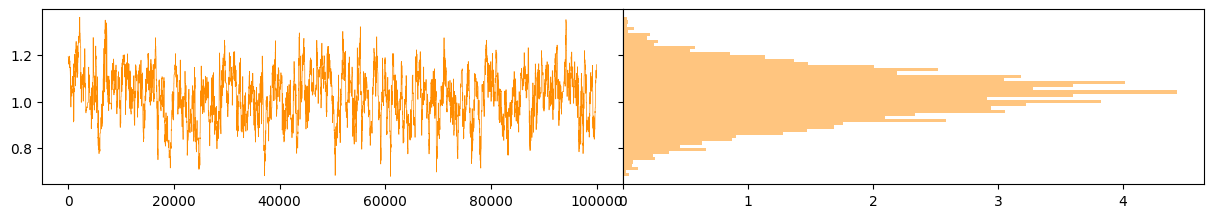

In [20]:
from MaCh3PythonUtils.file_handling.chain_diagnostics import ChainDiagnostics
plotter=ChainDiagnostics(chain_handler)

plotter("xsec_0")
plt.show()


## Machine learning
Okay now we've done some very basic file manipulation, it's time for some machine learning!
All algorithms use the same common `MLFactory` interface so let's go about configuring it!

In [21]:
# First step we need to initialise the factory

from pathlib import Path


model_output=Path("../models/my_model")
# Make sure the model output directory exists
model_output.parent.mkdir(parents=True, exist_ok=True)

# The factory produces ML models, we need to pass it the chain handler and the fitting label to get started
ml_factory = MLFactory(chain_handler, fitting_label, f"{model_output}.pdf")

Now we need to define a model, for this demonstration we'll make a very simple neural network!

In [22]:
# Finally we need to set the layers

# In the YAML format this would be simple but here we'll use some helper functions
def dense_layer(n_neurons: int, activation: str, regularize: bool = True):
    '''This function sets the properties of a dense layer'''
    return {'dense': {
        'units': n_neurons,
        'activation': activation,
        'kernel_regularizer': regularize,
        'kernel_initializer': tf.keras.initializers.HeUniform(seed=42),
        'bias_initializer': 'zeros'
    }}
    
def batch_norm(momentum: float = 0.9):
    '''This function sets the properties of a batch norm layer'''
    return {'batchnorm': {
        'momentum': momentum
    }}
    
def dropout_layer(dropout_rate: float):
    '''This function sets the properties of a dropout layer'''
    return {'dropout': {
        'rate': dropout_rate
    }}


In [23]:
layers = []

# Setup layers
layers.append(dense_layer(64, 'leaky_relu'))
layers.append(batch_norm(0.999))
layers.append(dense_layer(32, 'leaky_relu'))

layers.append(dense_layer(1, 'linear'))


In [24]:
# We now want the actual neural network properties
# Usually you set this using a YAML file (see configs for some examples) but we'll do this manually for now
build_settings = {
    # Loss function
    'loss': 'mse',
    # Metrics to measure
    'metrics': ['mae', 'mse'],
    # Learning 
    'learning_rate': 1e-6
}

# Settings used when the model is fitting
fit_settings = {
    'batch_size': 128,  # smaller batches often help stability
    'epochs': 20000,
    'validation_split': 0.2,
}

In [25]:
# Now we can make the model
ml_model = ml_factory.make_interface('TensorFlow', 'sequential', Layers=layers, FitSettings=fit_settings, BuildSettings=build_settings)

# Let's use 20% of the data for testing
ml_model.set_training_test_set(0.5)

In [26]:
# my_model = tf.keras.models.Sequential()
# npars = len(ml_model._training_data.columns)

# my_model.add(tf.keras.layers.Input(shape=(npars,)))
# my_model.add(tf.keras.layers.Dense(16, activation='leaky_relu', kernel_initializer='he_uniform', bias_initializer='ones'))
# my_model.add(tf.keras.layers.BatchNormalization(momentum=0.999))
# my_model.add(tf.keras.layers.Dense(8, activation='leaky_relu', kernel_initializer='he_uniform', bias_initializer='ones'))
# my_model.add(tf.keras.layers.Dense(1, activation='linear', kernel_initializer='he_uniform', bias_initializer='ones'))


In [27]:
# my_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
#     clipnorm=0.5,
#     learning_rate=0.000001),
#     metrics=['mae', 'mse'])
# my_model.build()

In [28]:
# scaled_data = ml_model.scale_data(ml_model._training_data)
# scaled_labs = ml_model.scale_labels(ml_model._training_labels)

# my_model.fit(scaled_data, scaled_labs, epochs=200, batch_size=128, validation_split=0.2)

In [29]:
# ml_model._model = my_model
# ml_model.test_model()

In [ ]:
# Now we need to train our network
ml_model.train_model()

Epoch 1/20000


Training Results!
[0.00173865 0.00173866 0.00173866 ... 0.00173866 0.00173866 0.00173865]
Mean Absolute Error : 0.7867501196485236
Line of best fit : y=-6.714113129330636e-07x + -1.1673529908494458e-09
Saving QQ to train_qq_plot.pdf


/Users/henrywallace/software/MaCh3/MaCh3-PythonUtils/src/MaCh3PythonUtils/machine_learning/file_ml_interface.py:299: RankWarning: Polyfit may be poorly conditioned
  lobf = np.poly1d(np.polyfit(predicted_values, true_values, 1))


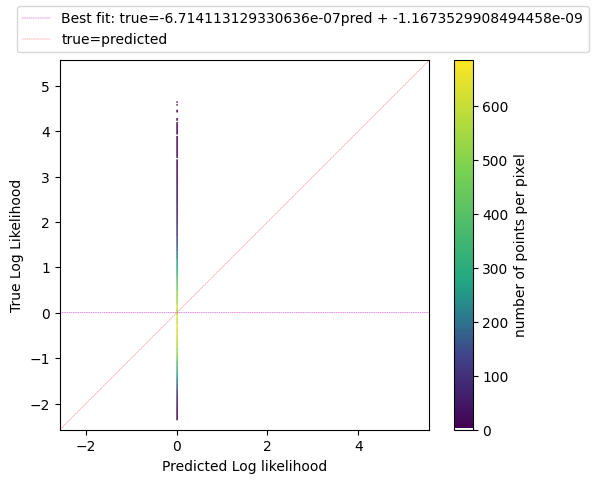

mean: -0.0017386555280849542, std dev: 1.0000000000081184
=====


Testing Results!
[0.00173866 0.00173866 0.00173866 ... 0.00173865 0.00173865 0.00173866]
Mean Absolute Error : 0.7906841267726568
Line of best fit : y=-0.21730623109258312x + -0.0003778206777316686
Saving QQ to .pdf


/Users/henrywallace/software/MaCh3/MaCh3-PythonUtils/src/MaCh3PythonUtils/machine_learning/file_ml_interface.py:299: RankWarning: Polyfit may be poorly conditioned
  lobf = np.poly1d(np.polyfit(predicted_values, true_values, 1))


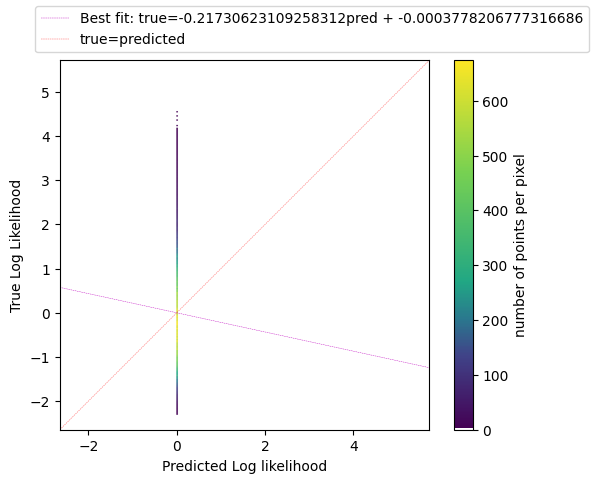

mean: -0.0024942931449972294, std dev: 1.0006343410563017
=====


[array([[ 5.5201376e-06, -6.5946479e-05,  1.3593007e-07, ...,
         1.0346128e-05,  2.5376459e-05,  2.1211245e-06],
       [-5.7623938e-06,  4.8968859e-06,  1.0865413e-05, ...,
         2.9919038e-06, -5.9218642e-06, -8.9500609e-06],
       [ 2.7952749e-06,  6.6918983e-06, -7.8973662e-06, ...,
         7.7838058e-07,  1.9113881e-05, -1.8840492e-05],
       ...,
       [-3.6874799e-06,  4.5236520e-06,  1.1769639e-05, ...,
        -1.9374447e-06, -1.3394224e-06,  4.1089111e-06],
       [-8.1681483e-06,  1.7011629e-05, -6.1200946e-05, ...,
         1.1694783e-06,  1.2626202e-05,  2.6819969e-06],
       [-4.5046954e-06, -6.2460449e-06, -2.0071984e-06, ...,
        -6.7340634e-06, -5.5613518e-06,  6.1432020e-06]], dtype=float32), array([0.87294984, 0.7846554 , 1.1328174 , 0.8120081 , 0.9077654 ,
       0.86705244, 1.1251464 , 0.81031114, 0.790318  , 0.88614166,
       0.8546757 , 0.8902989 , 0.8535649 , 1.0761236 , 1.02929

In [ ]:
# Now we need to test
ml_model.test_model()


In [ ]:
# Now we can save it
ml_model.save_model(f"{model_output}.keras")


# We need to save the scaling information
ml_model.save_scaler(str(model_output.parent.joinpath(Path("my_scaler.pkl"))))
print("Model saved to: ", model_output)
print("Scaler saved to: ", model_output.parent.joinpath(Path("my_scaler.pkl")))



Model saved to:  ../models/my_model
Scaler saved to:  ../models/my_scaler.pkl


In [ ]:
ml_model._model.summary()

print(ml_model._model.weights)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,077 (43.27 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 7,300 (28.52 KB)

[<Variable path=sequential/dense/kernel, shape=(21, 64), dtype=float32, value=[[ 5.5201376e-06 -6.5946479e-05  1.3593007e-07 ...  1.0346128e-05
   2.5376459e-05  2.1211245e-06]
 [-5.7623938e-06  4.8968859e-06  1.0865413e-05 ...  2.9919038e-06
  -5.9218642e-06 -8.9500609e-06]
 [ 2.7952749e-06  6.6918983e-06 -7.8973662e-06 ...  7.7838058e-07
   1.9113881e-05 -1.8840492e-05]
 ...
 [-3.6874799e-06  4.5236520e-06  1.1769639e-05 ... -1.9374447e-06
  -1.3394224e-06  4.1089111e-06]
 [-8.1681483e-06  1.7011629e-05 -6.1200946e-05 ...  1.1694783e-06
   1.2626202e-05  2.6819969e-06]
 [-4.5046954e-06 -6.2460449e-06 -2.0071984e-06 ... -6.7340634e-06
  -5.5613518e-06  6.1432020e-06]]>, <Variable path=sequential/dense/bias, shape=(64,), dtype=float32, value=[0.87294984 0.7846554  1.1328174  0.8120081  0.9077654  0.86705244
 1.1251464  0.81031114 0.790318   0.88614166 0.8546757  0.8902989
 0.8535649  1.0761236  1.0292984  1.1360459  1.0310484  0.9072888
 0.78754807 1.090932   1.1044357  0.9193688  1.02